In [1]:
import torch
import matplotlib.pyplot as plt

Classical damped harùonic oscillator :
$$ \frac{d^2 x}{d t^2} + 2 \zeta \omega_0 \frac{dx}{dt} + \omega_0^2 x = 0 $$
$$ \omega_0 = \sqrt{\frac{k}{m}} $$
$$ \zeta = \frac{c}{2 \sqrt{mk}} $$

Damped sinusoidal oscillations :
$$ z(t) = A e^{\zeta \omega_0 t} \times \sin(\sqrt{1-\zeta^2} \omega_0 t + \phi)$$

Step input :
$$ x(t) = 1- e^{-\zeta \omega_0 t} * \frac{\sin(\sqrt{1-\zeta^2} \omega_0 t + \phi)}{\sin(\phi)} $$

In [2]:
def damped_oscillator(t,
                      A=torch.Tensor([1]),
                      phi=torch.Tensor([1]),
                      m=torch.Tensor([50]),
                      k=torch.Tensor([1]),
                      c=torch.Tensor([1])):
    zeta = c / (2 * torch.sqrt(m * k))
    omega_0 = torch.sqrt(k / m)
    activity = A * torch.exp(zeta * omega_0 * t) * torch.sin(torch.sqrt(1 - zeta**2) * omega_0 * t + phi)
    return activity

In [3]:
x = torch.linspace(0, 500, 100_000)

In [4]:
y = damped_oscillator(t=x,
                      c=torch.Tensor([-1]), # damped parameter
                      A=torch.Tensor([-1]), # start direction
                      phi=torch.Tensor([0]), # start state
                      k=torch.Tensor([1]),
                      m=torch.Tensor([35])
                      )

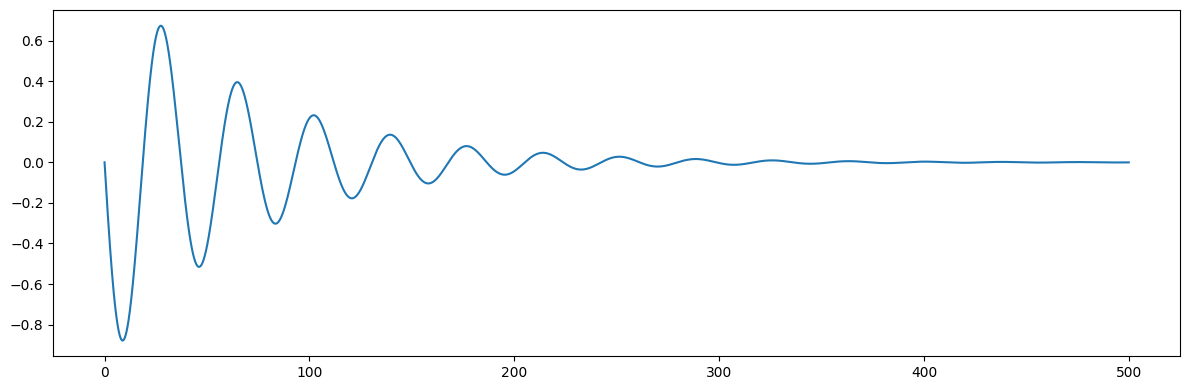

In [5]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
ax.plot(x, y)
plt.tight_layout()
plt.show()

In [6]:
class DampedOscillator(torch.nn.Module):
    def __init__(self,
                 c,
                 A,
                 phi,
                 k,
                 m
                ):
        super(DampedOscillator, self).__init__()

        self.c = torch.nn.Parameter(c * torch.ones(1))
        self.A = torch.nn.Parameter(A * torch.ones(1))
        self.phi = torch.nn.Parameter(phi * torch.ones(1))
        self.k = torch.nn.Parameter(k * torch.ones(1))
        self.m = torch.nn.Parameter(m * torch.ones(1))

    def forward(self, t):
        
        zeta = self.c / (2 * torch.sqrt(self.m * self.k))
        omega_0 = torch.sqrt(self.k / self.m)
        activity = self.A * torch.exp(zeta * omega_0 * t) * torch.sin(torch.sqrt(1 - zeta**2) * omega_0 * t + self.phi)

        return activity

In [7]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [8]:
lr = 1e-3
batch_size = 64*8
num_epochs = 200
device = "cpu"
criterion = torch.nn.MSELoss(reduction="mean")
# criterion = torch.nn.PoissonNLLLoss(reduction="mean")

In [9]:
def training(
        X,
        Y,

        lr=lr,
        num_epochs=num_epochs,
        device=device,
        criterion=criterion,
        batch_size=batch_size):

    # model initialisation
    model = DampedOscillator(c=-10,
                             A=-10,
                             phi=10,
                             k=15,
                             m=50)
    
    # Optimizer initialisation
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Loader initialisaiton
    dataloader = DataLoader(
                        TensorDataset(X, Y),
                        batch_size=batch_size, shuffle=True
                        )
    
    # Training
    losses = []

    for _ in tqdm(range(num_epochs)):

        total_loss = 0

        for batch_X, batch_Y in dataloader:

            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            model.train()
            model.to(device)
            outputs = model(t=batch_X)

            loss = criterion(outputs, batch_Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        losses.append(total_loss)
    
    return model, losses

In [10]:
lr = 1e-3
batch_size = 64 * 10
num_epochs = 100

In [14]:
model, loss = training(X=x, Y=y,
                       lr=lr,
                       num_epochs=num_epochs,
                       batch_size=batch_size,
                       device="cpu")

100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


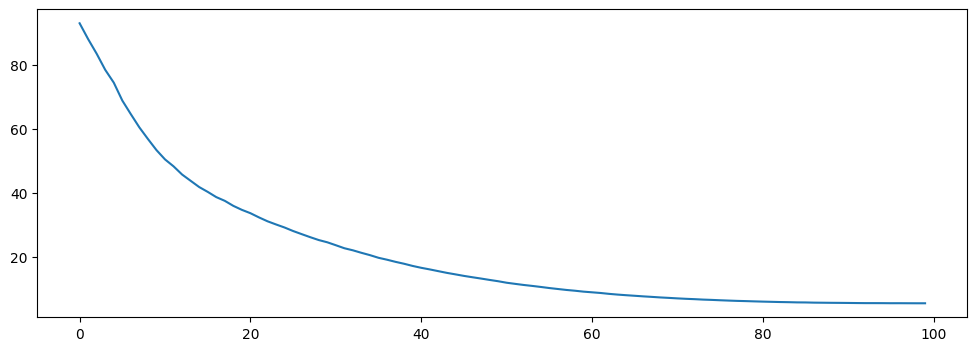

In [15]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
ax.plot(range(num_epochs), loss)
plt.show()

In [16]:
y_pred = model(x)

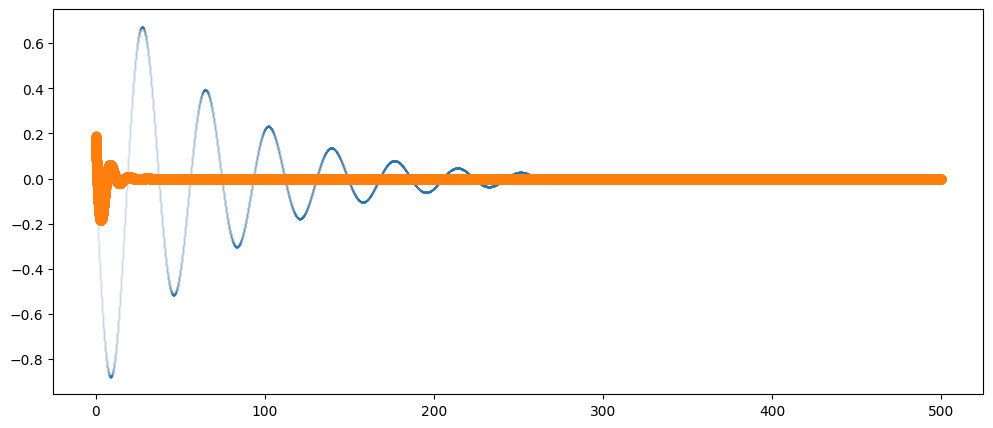

In [28]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
ax.plot(x, y, "o", markersize=0.01)
ax.plot(x, y_pred.cpu().detach(), "o")
plt.show()